# Exemplo de consulta usando filtros e SQL

Na página de cada recurso há um botão que lista exemplos de como consultar aquele recurso.  
![botão api dados](botao-api-dados.png).

O exemplo abaixo baixa os dados de lucros do BNDES e traça um gráfico. Note que valores não foram corrigidos pela inflação. 

In [1]:
# todas bibliotecas utilizadas estão no arquivo requirements.txt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set()

O identificador de cada resource fica no URL:  
![Encontrando no URL o id do recurso](id-de-recurso.png)

Evitaremos ao máximo mudar o identificador de cada recurso, mas se você quiser tornar seu código mais robusto pode buscar pelo nome como é feito no [exemplo de busca na api](python-api.ipynb).

In [2]:
res_id = '1090d538-d01c-4433-909b-67151ed7eb08'
res_id = '607b8cfc-66a1-4053-9771-c765ba79f7d4' # em homologação
#res_id = 'f6535586-9193-4264-af9e-ec5723d79ae3' # em dsv
server = 'https://dadosabertos.bndes.gov.br'

## Usando um filtro simples

O exemplo abaixo fará um filtro para pegar apenas os desembolsos contratados utilizando o parâmetro `filter`. 

Tamém utilzaremos o parâmetro `fields` para retornar apenas as colunas que interessam. Assim teremos um arquivo mais leve e mais fácil de trabalhar em máquinas menos poderosas.

Veja [documentação da api de busca](https://docs.ckan.org/en/ckan-2.2.3/datastore.html#ckanext.datastore.logic.action.datastore_search).

In [3]:
def quote(obj):
    return requests.utils.quote(json.dumps(obj))

filtros = quote({'nivel_atual': ['CONTRATADA', ' CONTRATADA']}) # pode-se passar múltiplos valores no filtro
campos = 'uf,data_do_nivel_atual,valor_desembolsado_em_reais'
consulta = (f"{server}/api/3/action/datastore_search?resource_id={res_id}"
           f"&filters={filtros}&fields={campos}&limit=10000"
           )

print(consulta)


https://dadosabertos-h.bndes.gov.br/api/3/action/datastore_search?resource_id=607b8cfc-66a1-4053-9771-c765ba79f7d4&filters=%7B%22nivel_atual%22%3A%20%5B%22CONTRATADA%22%2C%20%22%20CONTRATADA%22%5D%7D&fields=uf,data_do_nivel_atual,valor_desembolsado_em_reais&limit=10000


In [4]:
data = requests.get(consulta)
data.raise_for_status()

df = pd.DataFrame(data.json()['result']['records'])
df['data_do_nivel_atual'] = pd.to_datetime(df.data_do_nivel_atual)
df.head()

,uf,data_do_nivel_atual,valor_desembolsado_em_reais
0,SP,2007-01-02,1202585
1,SC,2010-01-02,1250000
2,SC,2011-01-02,424000
3,PB,2011-01-02,246000
4,RS,2007-01-03,341500


In [5]:
# agrupando valores por estado e por ano
df_uf = (df.groupby([df.uf, df.data_do_nivel_atual.dt.year ])
           .sum()
           .reset_index()
           .rename(columns={"valor_desembolsado_em_reais": "Valor Desembolsado", "data_do_nivel_atual": "Ano", "uf": "UF"})
        )

In [6]:
df_uf[df_uf.UF==' RJ']

,UF,Ano,Valor Desembolsado
269,RJ,1996,510907101
270,RJ,1997,229927260
271,RJ,1998,16865682
272,RJ,2000,95753481
273,RJ,2001,233498969
274,RJ,2002,249936053
275,RJ,2003,9386662
276,RJ,2004,16268039
277,RJ,2006,305103797
278,RJ,2007,15473988


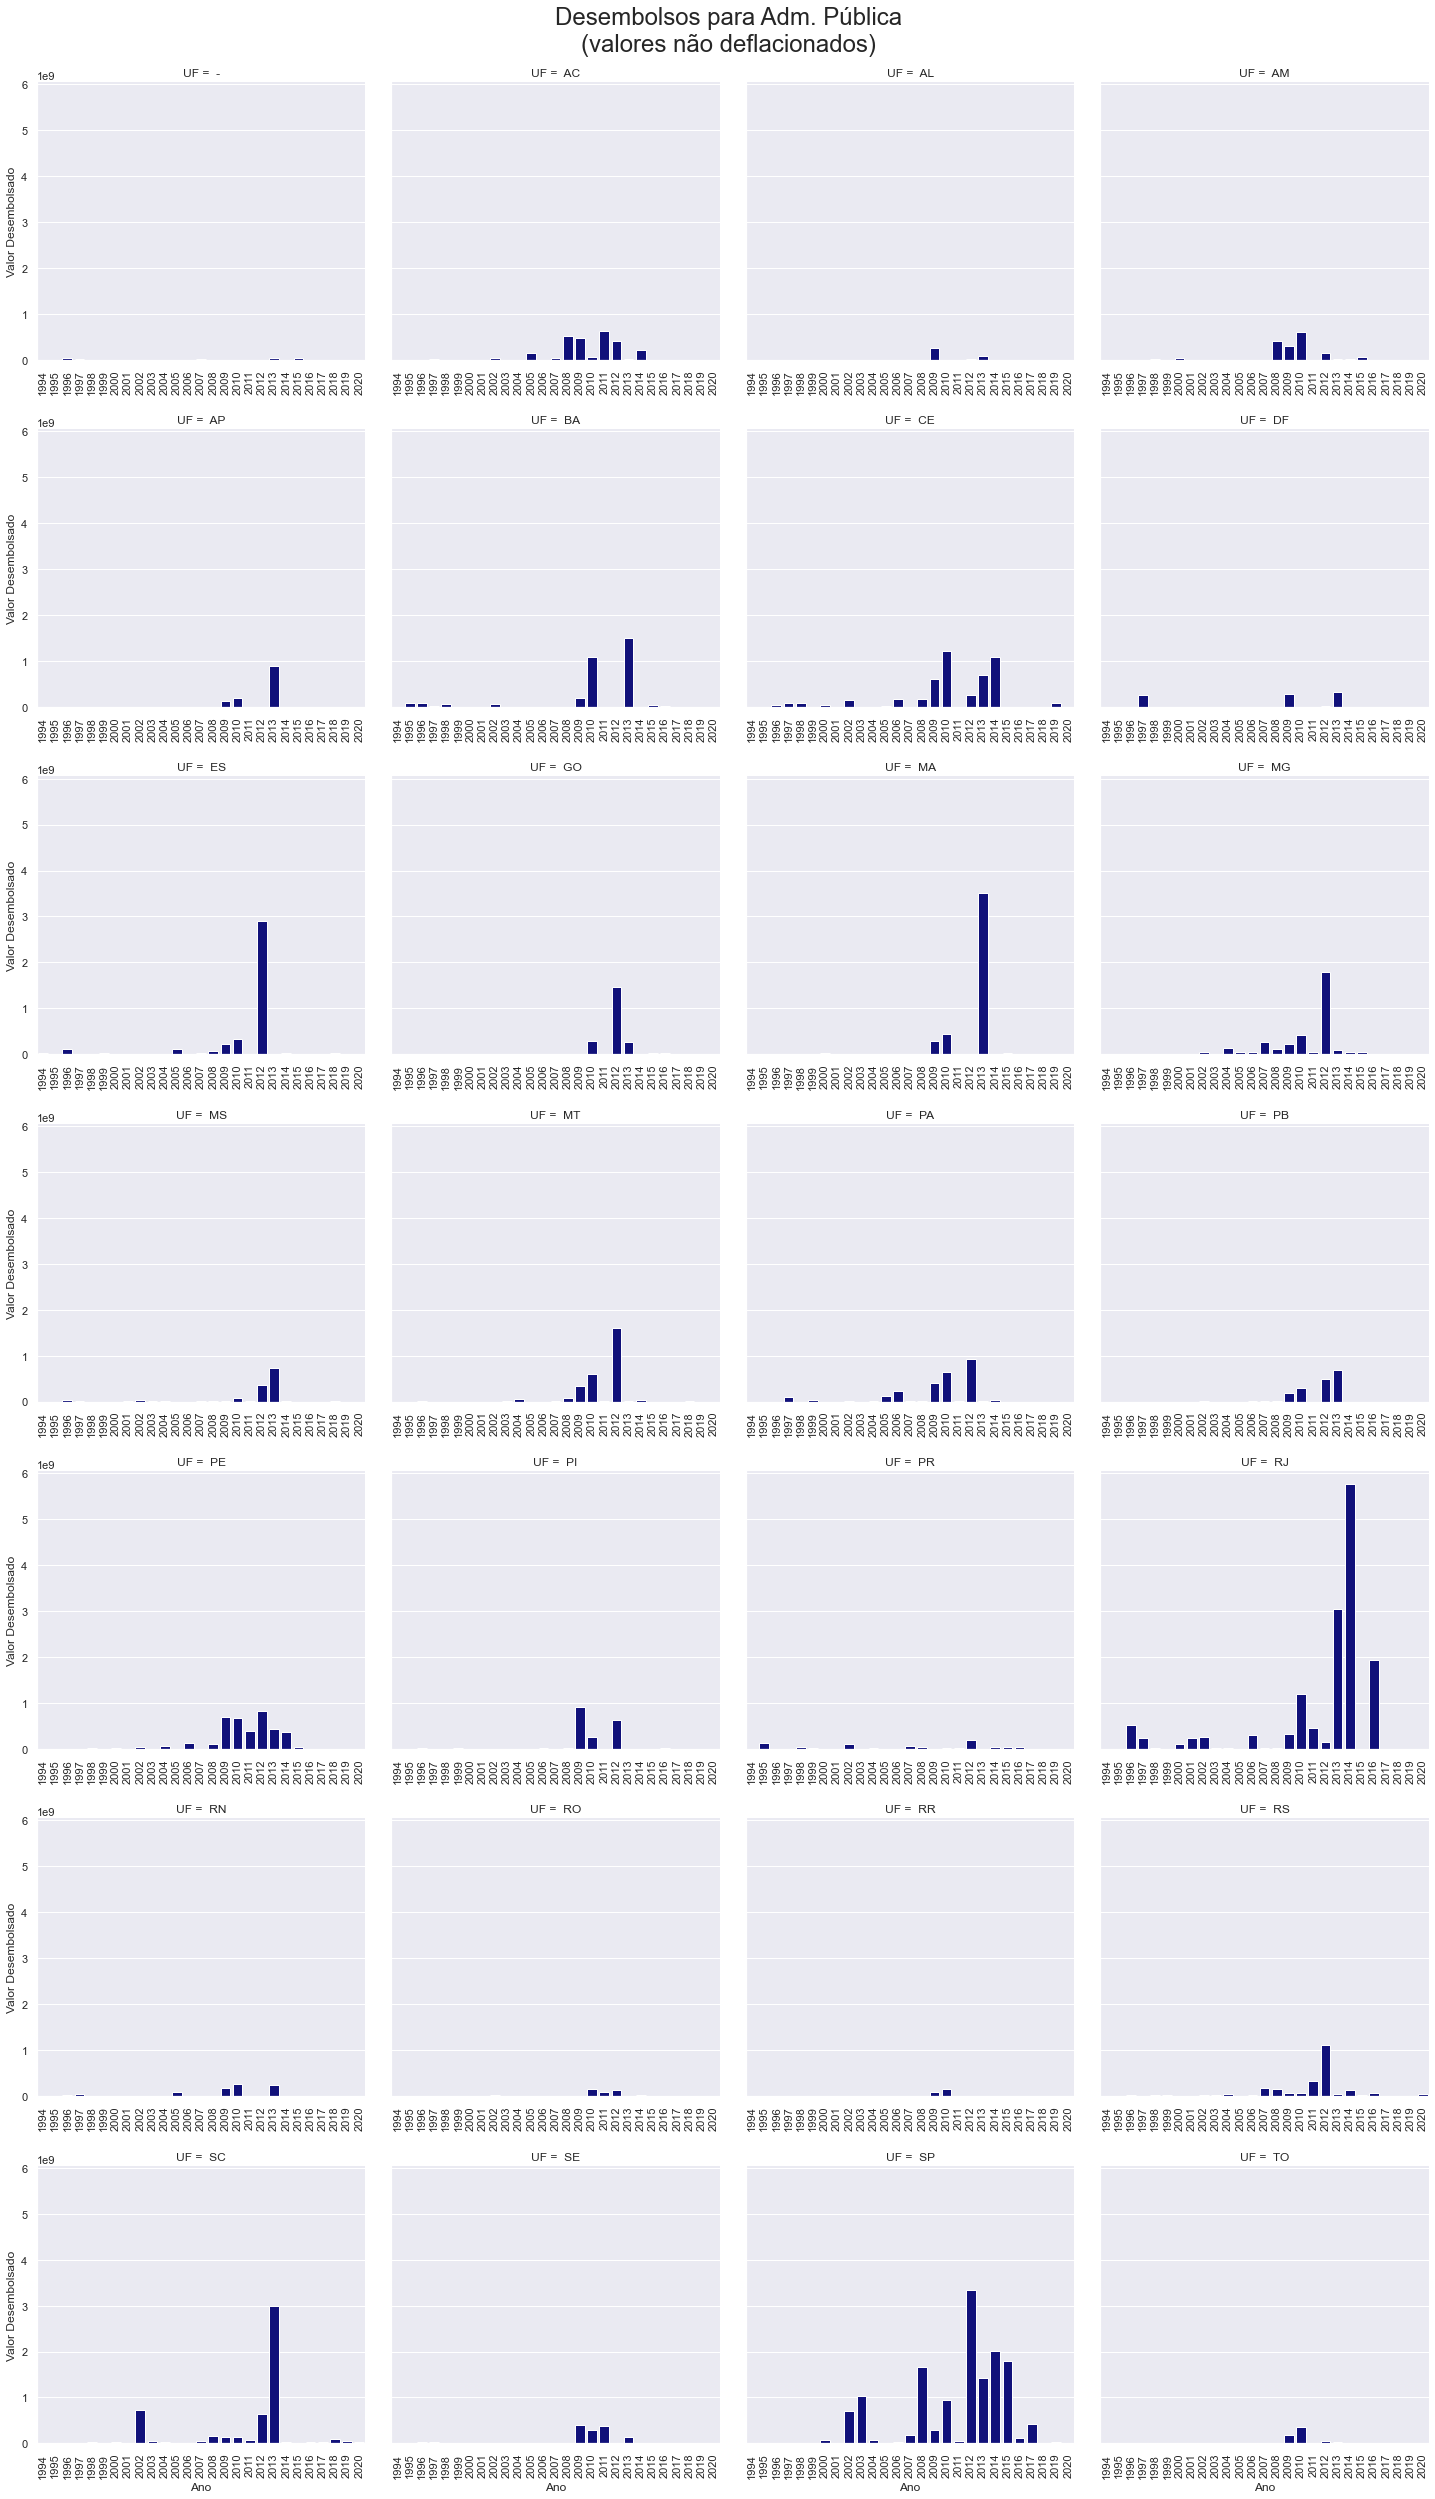

In [7]:
g = sns.catplot(data=df_uf, kind='bar',
                x='Ano', y="Valor Desembolsado", col="UF", 
                col_wrap=4, color="darkblue")
g.fig.subplots_adjust(top=.95, hspace=0.25)
g.fig.suptitle("Desembolsos para Adm. Pública\n(valores não deflacionados)", fontsize=24)
g.set_xticklabels(rotation='vertical');
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

## Fazendo Filtros com SQL

Pode-se usar SQL para fazer filtros mais sofisticados. No exemplo abaixo, os dados de Indicadores Financeiros têm valores trimestrais. Os valores no meio do ano representam o valor acumulado até o momento no ano. 

Para fazer comparações anuais, vamos filtrar para pegar **apenas os valores de dezembro**. 

Veja a [documentação do método datastore_search_sql](https://docs.ckan.org/en/ckan-2.2.3/datastore.html#ckanext.datastore.logic.action.datastore_search_sql). Utiliza-se a sintaxe do [Postgresql](https://www.postgresql.org/docs/9.5/sql-select.html).

In [8]:
resource_id = '9a62fc51-61bd-467e-ae95-0def93cb2f92'
#resource_id = '8b0dff84-1d82-46c0-b14c-c23446120c6f' # hom 
#resource_id = '78a6ebda-2bd1-45e8-8648-82a9ac70a351' #dev

server = 'https://dadosabertos.bndes.gov.br' #hom
#server = 'https://dadosabertos-h.bndes.gov.br' #hom

# usando função SQL para só pegar mês 12. SQL
consulta = requests.utils.quote(f'SELECT EXTRACT(YEAR from data) as ano, * from "{resource_id}"  WHERE EXTRACT(MONTH from data) = 12')
api_url = f"{server}/api/3/action/datastore_search_sql?sql={consulta}"
print(api_url)
          
data_ll = requests.get(api_url)
data_ll.raise_for_status()


https://dadosabertos-h.bndes.gov.br/api/3/action/datastore_search_sql?sql=SELECT%20EXTRACT%28YEAR%20from%20data%29%20as%20ano%2C%20%2A%20from%20%228b0dff84-1d82-46c0-b14c-c23446120c6f%22%20%20WHERE%20EXTRACT%28MONTH%20from%20data%29%20%3D%2012


In [9]:
df_ll = pd.DataFrame(data_ll.json()['result']['records'])
df_ll = df_ll.astype({'ano':int, 'lucro_liquido': int})
df_ll.head()

,inadimplencia_90_dias,spread_medio_nis_pp_a_a,inadimplencia_30_dias,despesas_administrativas,patrimonio_liquido_pl,ano,_full_text,indice_de_basileia,ativo_total,retorno_sobre_o_ativo_pp_a_a,indice_eficiencia_despesas_adm_por_ativo_total,margem_liquida_de_juros_nim_pp_a_a,lucro_liquido,retorno_sobre_instrumentos_de_capital_pp_a_a,retorno_sobre_pl_pp_a_a,_id,data,creditos_renegociados,alavancagem
0,None,None,0.00520894792737816320765675826010010496247559...,455,12350,2002,'-12':2 '-31':3 '0.003457840939316791234459103...,None,150958,0.00417980772884447328296975143757663317956030...,0.00345784093931679123445910306600126205012202...,None,550,0.04480104264244694906027532965708815027028322...,0.04480104264244694906027532965708815027028322...,4,2002-12-31T00:00:00,None,12.2233198380566800977931052329950034618377685...
1,None,None,0.03076210916130118350197975019000296015292406...,562,12857,2003,'-12':2 '-31':3 '0.003708555082271192994414210...,0.14303657314680537360196410645585274323821067...,152125,0.00684960885302045990874475478449312504380941...,0.00370855508227119299441421063079360465053468...,None,1038,0.08235807513785853295473771140677854418754577...,0.08235807513785853295473771140677854418754577...,8,2003-12-31T00:00:00,None,11.8320759119545773074833050486631691455841064...
2,0.00459999999999999992228438827623904217034578...,None,0.00644821376615002314625080259702372131869196...,796,14115,2004,'-12':2 '-31':3 '0.004599999999999999922284388...,0.15359420543583240936769129802996758371591567...,163959,0.00947849305880715288508131521894028992392122...,0.00503663583098163791101908870473380375187844...,None,1498,0.11107815512383212297464751827646978199481964...,0.11107815512383212297464751827646978199481964...,12,2004-12-31T00:00:00,None,11.6159404888416570855724785360507667064666748...
3,0.01409999999999999968636199554339327733032405...,None,0.02081483246334120407183831957809161394834518...,701,15711,2005,'-12':2 '-31':3 '0.004136596189138632036208509...,0.16710355006681784639788190816034330055117607...,174967,0.01889498002513823049497432293719612061977386...,0.00413659618913863203620850939046249550301581...,None,3202,0.21471199624488701562796677535516209900379180...,0.21471199624488701562796677535516209900379180...,16,2005-12-31T00:00:00,None,11.1365921965501879498106063692830502986907958...
4,0.00659999999999999996391775169968241243623197...,None,0.00680470046753384183446655697480309754610061...,701,19092,2006,'-12':2 '-31':3 '0.003868205119715706092470286...,0.23173194395872845352535307483776705339550971...,187475,0.03493524481158364475286148831401078496128320...,0.00386820511971570609247028649235744524048641...,None,6331,0.31442957342495481132260692902491427958011627...,0.36381921098755853893891298866947181522846221...,20,2006-12-31T00:00:00,None,9.81955793002304666572399582946673035621643066...


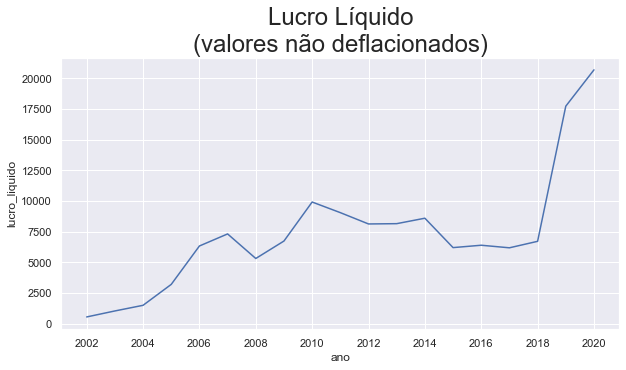

In [10]:
ax = sns.lineplot(data=df_ll, x='ano', y='lucro_liquido')
ax.set_title("Lucro Líquido\n(valores não deflacionados)", fontsize=24)
ax.set_xticks(range(min(df_ll.ano), max(df_ll.ano)+1, 2))
plt.gcf().set_size_inches(10,5)